# **Predictive Modeling for Loan Recovery Optimization in Financial Institutions**

## **Abstract**

Loan default remains a critical challenge for financial institutions, leading to high non-performing loans (NPLs) and financial instability. Traditional recovery strategies often rely on reactive approaches, resulting in inefficiencies and resource wastage. This research proposes a predictive analytics model to optimize loan recovery by identifying high-risk borrowers and enabling targeted collection efforts. By leveraging machine learning techniques, the study aims to enhance recovery rates while minimizing operational costs. The model’s effectiveness will be assessed using AUC-ROC as the primary metric, complemented by Precision at K, Recovery Rate, and Operational Cost Reduction.

## **Introduction**

Loan delinquency significantly affects the financial health of lending institutions, leading to liquidity constraints and revenue losses. Conventional recovery strategies often follow generalized approaches that do not account for borrower-specific risk levels. Predictive analytics offers a data-driven solution by enabling institutions to assess risk early and optimize collection efforts. This study explores the application of machine learning techniques to develop a loan recovery model that enhances financial sustainability.

## **Problem Statement**

Loan defaults contribute to financial losses and increased recovery costs for lenders. Current collection strategies are largely manual and inefficient, leading to suboptimal results. The lack of predictive capabilities limits institutions from prioritizing high-risk borrowers for targeted recovery efforts. This study aims to develop a machine learning model that classifies borrowers based on their likelihood of repaying overdue loans, improving the efficiency and effectiveness of recovery strategies.

## **Objectives**

The key objectives of this study are:

1. To analyze historical loan repayment data and identify key risk factors influencing default.

2. To develop a predictive model for classifying borrowers based on their likelihood of repayment.

3. To evaluate model performance using relevant success metrics, ensuring both technical accuracy and business applicability.

4. To assess the impact of the model on loan recovery rates and operational efficiency.

5. To propose a data-driven strategy for optimizing loan collection efforts.


## **Metric of Success**

The primary objective of this study is to develop a machine learning model capable of classifying loan recovery outcomes into three categories: Fully Recovered, Partially Recovered, and Written Off. The model's success is evaluated based on key performance metrics, including Logarithmic Loss (Log Loss), Recall, F1-Score, and Accuracy. These metrics were selected to balance overall model performance while ensuring the model correctly identifies high-risk cases (i.e., loans that are only partially recovered or completely written off).

The model is considered successful if:

- Log Loss ≤ 0.70 is achieved, indicating that the model makes well-calibrated probabilistic predictions.

- Log Loss ≤ 0.50 is considered excellent, demonstrating highly confident and reliable predictions.

- Recall for Partially Recovered (Class 1) ≥ 70%, ensuring that at least 70% of partially recovered loans are correctly classified.

- Recall for Written Off (Class 2) ≥ 60%, ensuring that a majority of high-risk cases are correctly flagged.

To balance precision and recall, the weighted F1-score is also used. The model must achieve:

- Weighted F1-score ≥ 0.75 to maintain an overall strong classification performance.

## **Dataset**

This dataset contains information about borrowers, loans, and their repayment status.

1. **Borrower Information**

These columns describe the borrower’s profile:

- Borrower_ID – A unique identifier for each borrower (Not useful for analysis).

- Age – The borrower's age. Helps determine if younger or older individuals default more.

- Gender – Male or Female. May indicate trends in repayment behavior.

- Employment_Type – Categorizes borrowers as Salaried or Self-Employed.

- Monthly_Income – How much a borrower earns per month. Critical for assessing their ability to repay.

- Num_Dependents – Number of people financially dependent on the borrower.

2. **Loan Details**

These columns describe the loan given to the borrower:

- Loan_ID – A unique identifier for each loan (Not useful for analysis).

- Loan_Amount – The total amount borrowed.

- Loan_Tenure – Loan duration in months (e.g., 12 months, 24 months, etc.).

- Interest_Rate – The rate charged on the loan (% per year).

- Loan_Type – Could be Personal Loan, Mortgage, Auto Loan, Education Loan, etc.

- Collateral_Value – If the loan is secured, this is the value of the asset used as collateral.

- Outstanding_Loan_Amount – The amount still unpaid by the borrower.

- Monthly_EMI – The fixed Equated Monthly Installment (EMI) the borrower must pay.

3. **Repayment & Loan Recovery Information**

These columns track how well borrowers are repaying their loans:

- Payment_History – Shows past repayment behavior:

"On-Time" → Paid without delays.

"Delayed" → Paid late but eventually cleared.

"Defaulted" → Failed to pay.

- Num_Missed_Payments – Number of times the borrower skipped payments.

- Days_Past_Due – The total days a borrower is overdue.


- Recovery_Status – The final status of the loan:

"Fully Recovered" → Loan paid in full.

"Partially Recovered" → Some payments made but not fully repaid.

"Not Recovered" → Borrower defaulted completely.

- Collection_Attempts – How many times the lender tried to recover money.

- Collection_Method – The strategy used to recover the loan, such as:

"Calls" → Contacting the borrower.

"Debt Collectors" → Hiring an agency.

"Legal Notice" → Sending a legal warning.

"Settlement Offer" → Offering a discount for early payment.

- Legal_Action_Taken – Indicates whether the borrower was sued for non-payment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from scipy.stats import chi2_contingency


ModuleNotFoundError: No module named 'pandas'

In [ ]:
data= pd.read_csv("data/loan-recovery.csv")
data.head()

,Borrower_ID,Age,Gender,Employment_Type,Monthly_Income,Num_Dependents,Loan_ID,Loan_Amount,Loan_Tenure,Interest_Rate,...,Collateral_Value,Outstanding_Loan_Amount,Monthly_EMI,Payment_History,Num_Missed_Payments,Days_Past_Due,Recovery_Status,Collection_Attempts,Collection_Method,Legal_Action_Taken
0,BRW_1,59,Male,Salaried,215422,0,LN_1,1445796,60,12.39,...,1.727997e+06,2.914130e+05,4856.88,On-Time,0,0,Partially Recovered,1,Settlement Offer,No
1,BRW_2,49,Female,Salaried,60893,0,LN_2,1044620,12,13.47,...,1.180032e+06,6.652042e+05,55433.68,On-Time,0,0,Fully Recovered,2,Settlement Offer,No
2,BRW_3,35,Male,Salaried,116520,1,LN_3,1923410,72,7.74,...,2.622540e+06,1.031372e+06,14324.61,Delayed,2,124,Fully Recovered,2,Legal Notice,No
3,BRW_4,63,Female,Salaried,140818,2,LN_4,1811663,36,12.23,...,1.145493e+06,2.249739e+05,6249.28,On-Time,1,56,Fully Recovered,2,Calls,No
4,BRW_5,28,Male,Salaried,76272,1,LN_5,88578,48,16.13,...,0.000000e+00,3.918989e+04,816.46,On-Time,1,69,Fully Recovered,0,Debt Collectors,No


In [ ]:
data.columns

Index(['Borrower_ID', 'Age', 'Gender', 'Employment_Type', 'Monthly_Income',
       'Num_Dependents', 'Loan_ID', 'Loan_Amount', 'Loan_Tenure',
       'Interest_Rate', 'Loan_Type', 'Collateral_Value',
       'Outstanding_Loan_Amount', 'Monthly_EMI', 'Payment_History',
       'Num_Missed_Payments', 'Days_Past_Due', 'Recovery_Status',
       'Collection_Attempts', 'Collection_Method', 'Legal_Action_Taken'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Borrower_ID              500 non-null    object 
 1   Age                      500 non-null    int64  
 2   Gender                   500 non-null    object 
 3   Employment_Type          500 non-null    object 
 4   Monthly_Income           500 non-null    int64  
 5   Num_Dependents           500 non-null    int64  
 6   Loan_ID                  500 non-null    object 
 7   Loan_Amount              500 non-null    int64  
 8   Loan_Tenure              500 non-null    int64  
 9   Interest_Rate            500 non-null    float64
 10  Loan_Type                500 non-null    object 
 11  Collateral_Value         500 non-null    float64
 12  Outstanding_Loan_Amount  500 non-null    float64
 13  Monthly_EMI              500 non-null    float64
 14  Payment_History          5

In [ ]:
data.drop(columns=['Borrower_ID', 'Loan_ID'], inplace=True)

In [ ]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])  # Only show columns with missing values

Number of duplicate rows: 0

Missing values per column:
Series([], dtype: int64)


In [ ]:
data.describe()

,Age,Monthly_Income,Num_Dependents,Loan_Amount,Loan_Tenure,Interest_Rate,Collateral_Value,Outstanding_Loan_Amount,Monthly_EMI,Num_Missed_Payments,Days_Past_Due,Collection_Attempts
count,500.000000,500.000000,500.000000,5.000000e+02,500.00000,500.000000,5.000000e+02,5.000000e+02,500.000000,500.000000,500.000000,500.000000
mean,43.116000,134829.920000,1.476000,1.024907e+06,46.10400,11.192820,6.032240e+05,5.627260e+05,15861.536020,1.912000,70.678000,3.000000
std,12.733217,68969.356746,1.145447,5.907556e+05,18.23706,3.775209,7.457131e+05,4.723581e+05,18709.231315,2.110252,60.211038,2.807805
min,21.000000,15207.000000,0.000000,5.413800e+04,12.00000,5.020000,0.000000e+00,1.571283e+04,261.880000,0.000000,0.000000,0.000000
25%,32.000000,76343.250000,0.000000,4.629848e+05,36.00000,7.907500,0.000000e+00,1.822072e+05,4039.097500,1.000000,4.000000,1.000000
50%,44.000000,134929.500000,1.000000,9.971240e+05,48.00000,10.915000,2.327684e+05,4.133240e+05,9330.170000,2.000000,66.500000,2.000000
75%,53.000000,193086.250000,3.000000,1.557952e+06,60.00000,14.577500,1.111106e+06,8.324787e+05,20439.485000,3.000000,122.250000,4.000000
max,64.000000,249746.000000,3.000000,1.995325e+06,72.00000,17.970000,2.744395e+06,1.932396e+06,127849.230000,12.000000,180.000000,10.000000


<Figure size 1400x1000 with 0 Axes>

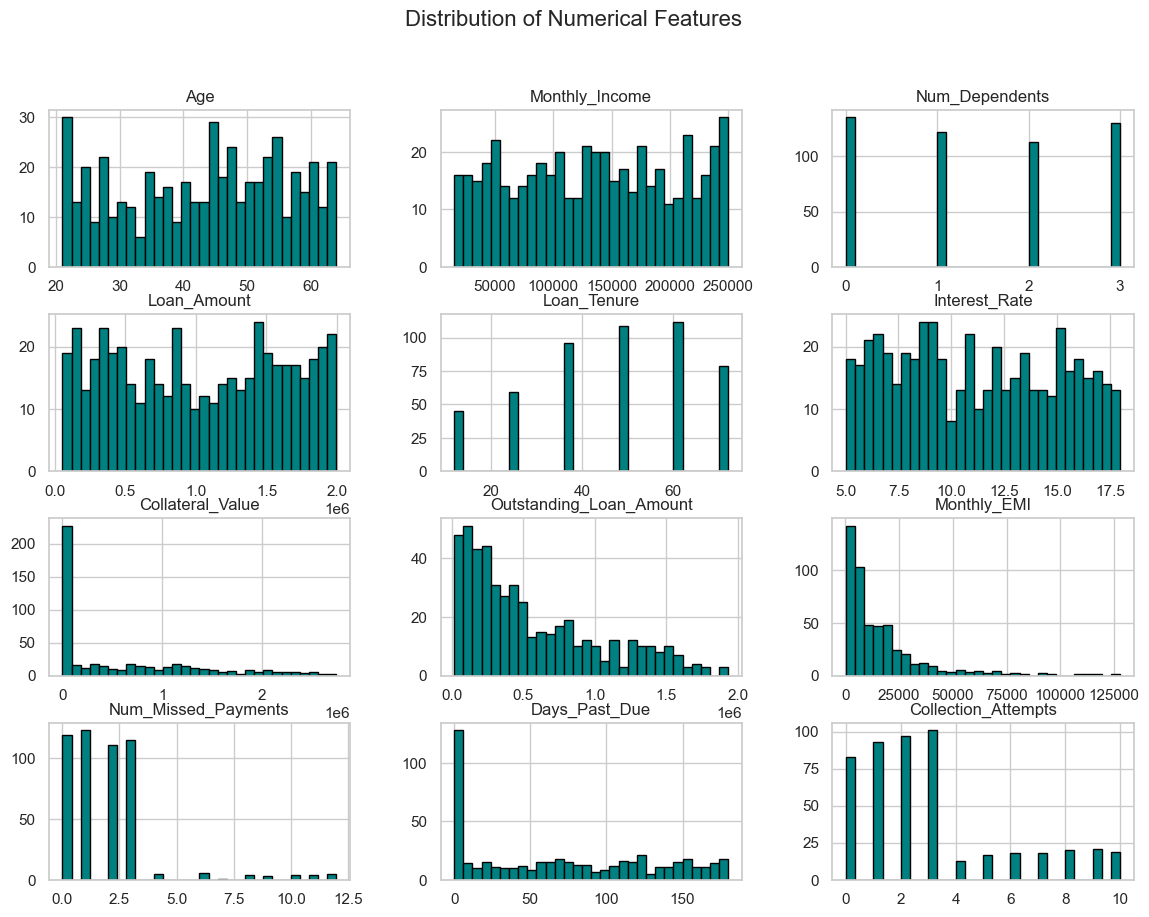

In [ ]:
#Set a consistent theme
sns.set_theme(style="whitegrid", palette="Set2")
histogram_color = "teal"

# Plot histograms for numerical features
plt.figure(figsize=(14, 10))
data.hist(figsize=(14, 10), bins=30, edgecolor='black', color=histogram_color)
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()


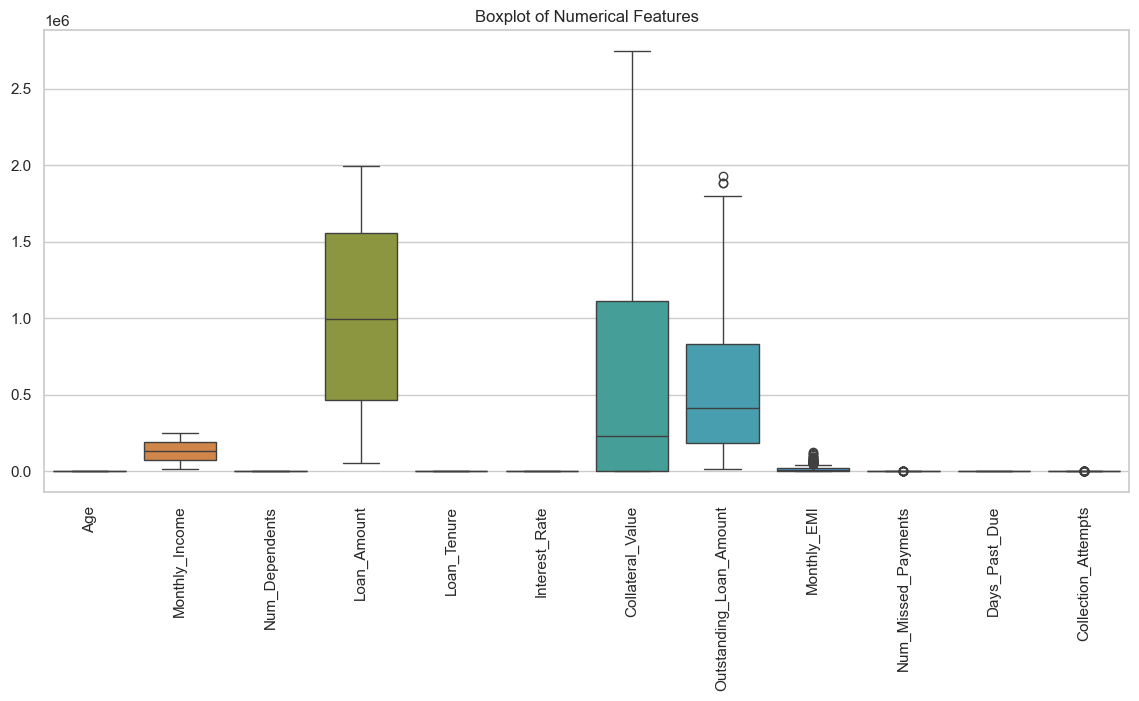

In [ ]:
# Boxplots to check for outliers
plt.figure(figsize=(14, 6))
sns.boxplot(data=data.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Features")
plt.show()

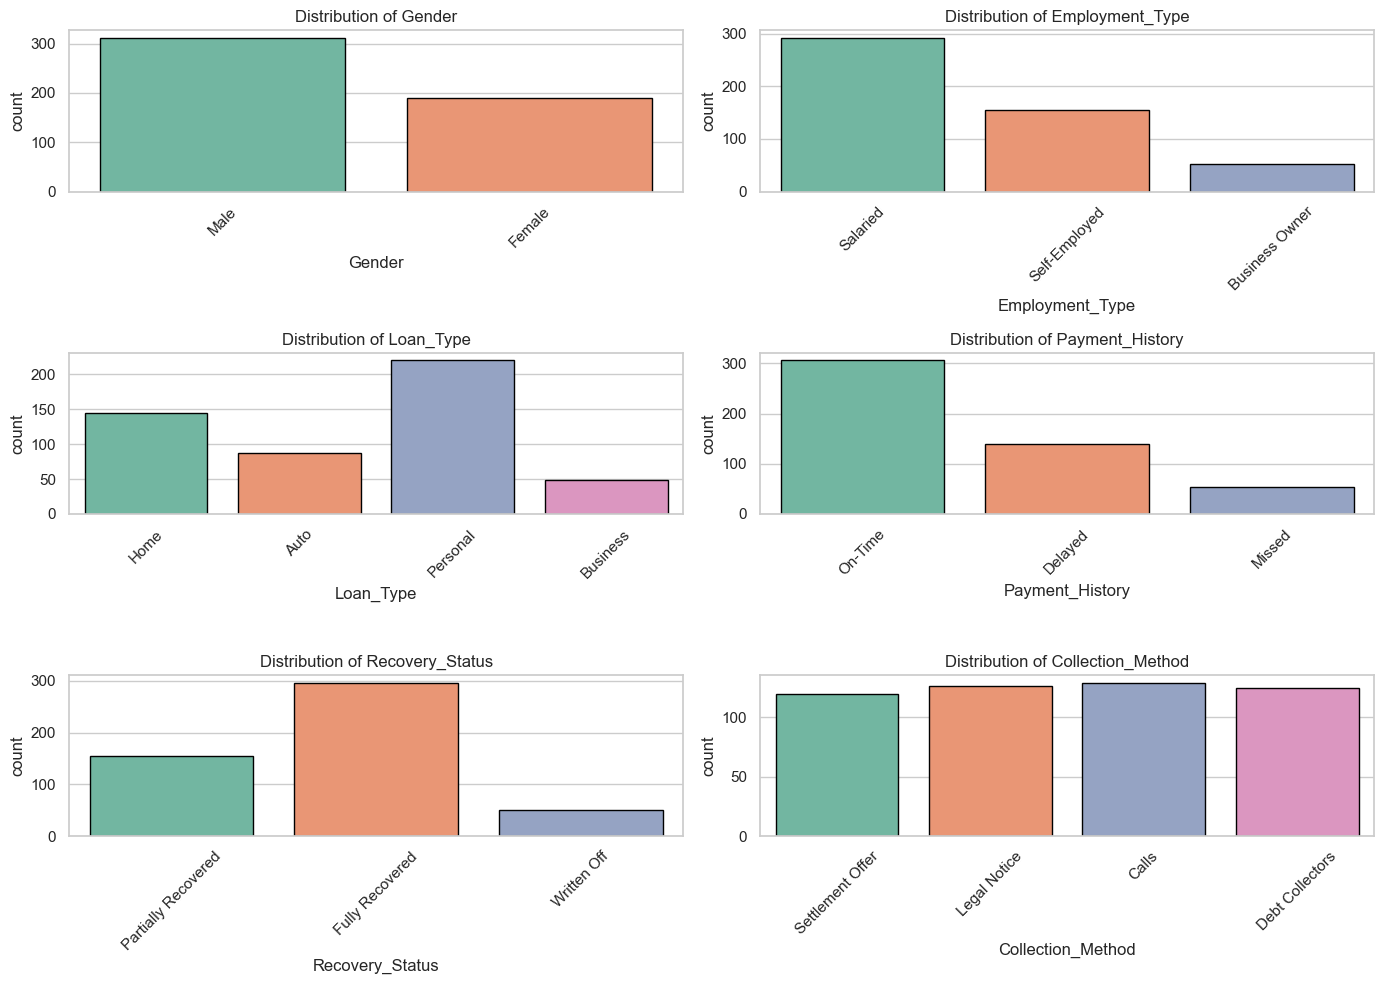

In [ ]:
# Categorical features
categorical_columns = ['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Recovery_Status', 'Collection_Method']

plt.figure(figsize=(14, 10))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, data=data, hue=col, palette="Set2", edgecolor="black", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

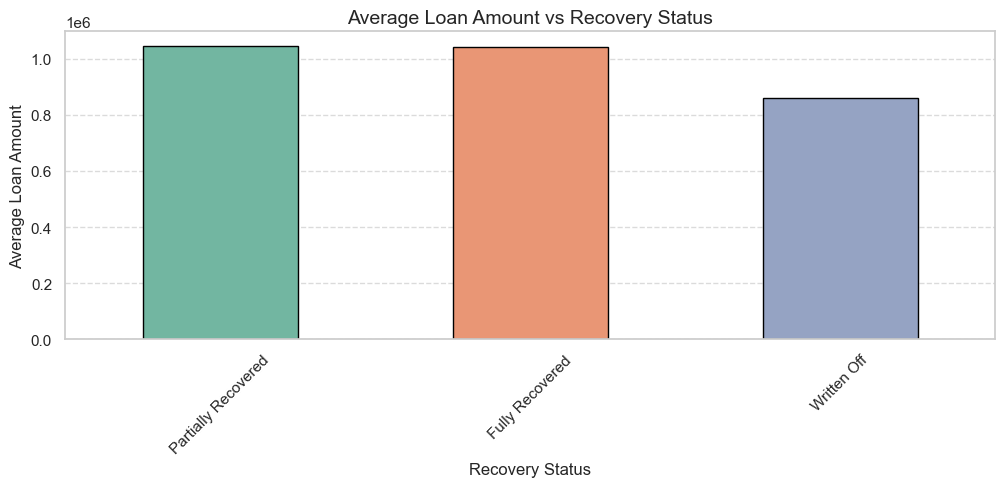

In [ ]:
plt.figure(figsize=(12, 4))

ax = sns.barplot(
    x='Recovery_Status', y='Loan_Amount', data=data, estimator=np.mean,
    hue='Recovery_Status', palette="Set2", edgecolor="black", width=0.5, dodge=False, errorbar=None 
)

plt.title("Average Loan Amount vs Recovery Status", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Average Loan Amount")
plt.xlabel("Recovery Status")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([],[], frameon=False)  # Hide legend since hue=x makes one

plt.show()

### **Do Interest Rates impact Recovery Status?**

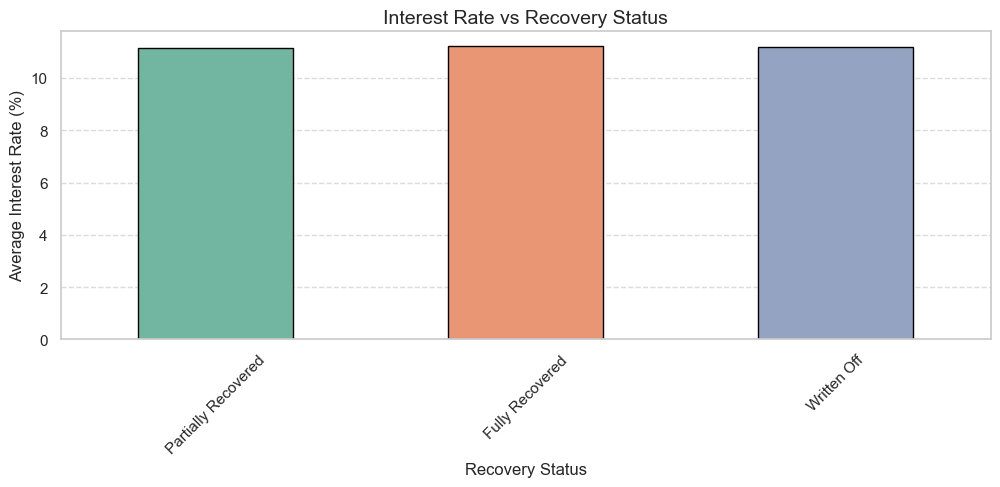

In [ ]:
plt.figure(figsize=(12, 4))

ax = sns.barplot(
    x='Recovery_Status', y='Interest_Rate', data=data, estimator=np.mean,
    hue='Recovery_Status', palette="Set2", edgecolor="black", width=0.5, dodge=False,
    errorbar=None  # Keeps bars clean
)

plt.title("Interest Rate vs Recovery Status", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Average Interest Rate (%)")
plt.xlabel("Recovery Status")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([],[], frameon=False)  # Hide legend if unnecessary

plt.show()

### **How does Payment History relate to Recovery Status?**

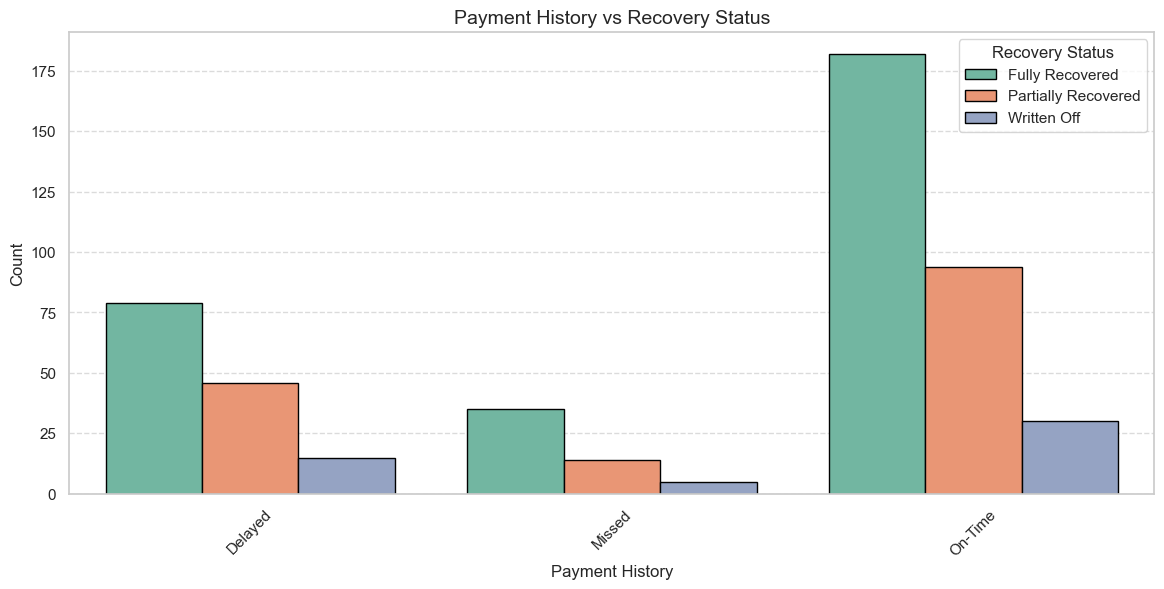

In [ ]:
# Create a crosstab for counts
crosstab_data = pd.crosstab(data['Payment_History'], data['Recovery_Status'])

# Convert to long format for Seaborn
crosstab_long = crosstab_data.reset_index().melt(id_vars="Payment_History", var_name="Recovery_Status", value_name="Count")

plt.figure(figsize=(14, 6))

ax = sns.barplot(
    x="Payment_History", y="Count", hue="Recovery_Status", data=crosstab_long,
    palette="Set2", edgecolor="black"
)

plt.title("Payment History vs Recovery Status", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.xlabel("Payment History")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Recovery Status")

plt.show()


### **What are the top collection methods used?**

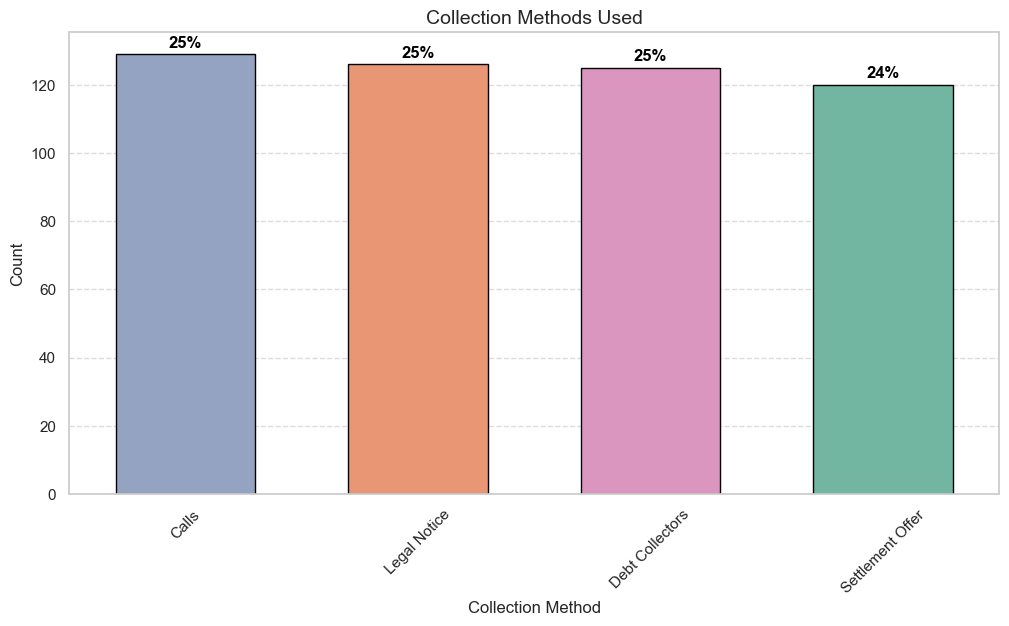

In [ ]:
plt.figure(figsize=(12, 6))  

ax = sns.countplot(
    x='Collection_Method', data=data, 
    hue='Collection_Method', palette="Set2",  
    order=data['Collection_Method'].value_counts().index, 
    edgecolor="black", width=0.6, legend=False  # Thinner bars with width=0.6
)

# Add percentage labels with whole numbers
total = len(data)  # Total count for percentage calculation
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100  # Convert to percentage

    ax.text(p.get_x() + p.get_width()/2, height + 2, f'{int(percentage)}%',  # No decimals
            ha='center', fontsize=12, fontweight='bold', color='black')

plt.title("Collection Methods Used", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.xlabel("Collection Method")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### **Does Employment Type affect Loan Recovery?**

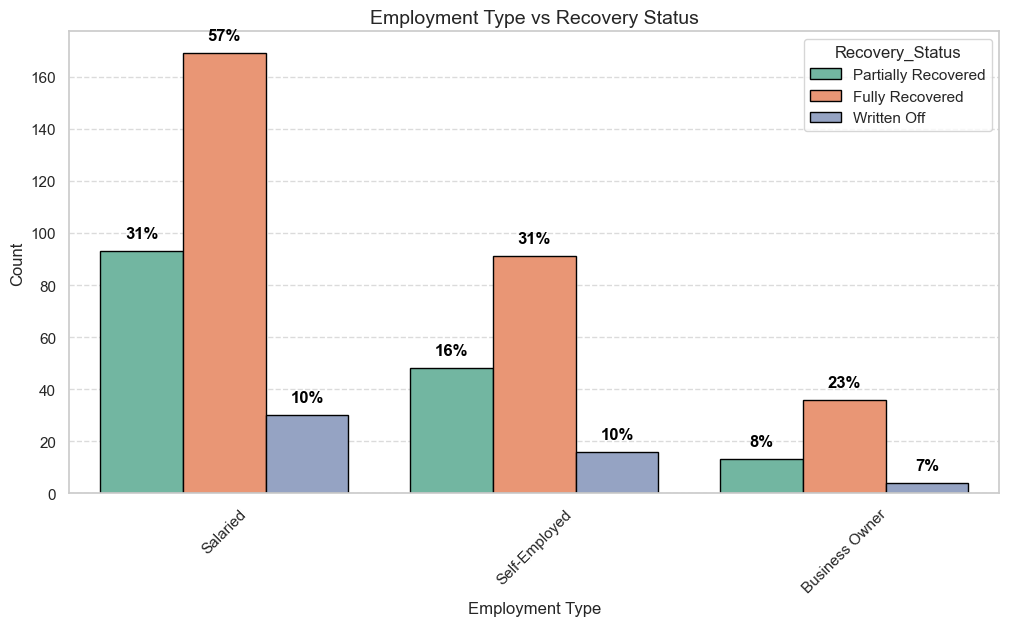

In [ ]:
plt.figure(figsize=(12, 6))  # Wider for better spacing

ax = sns.countplot(
    x='Employment_Type', hue='Recovery_Status', data=data, 
    palette="Set2", order=data['Employment_Type'].value_counts().index,  
    edgecolor="black"
)

# Compute total counts per category
total_counts = data['Employment_Type'].value_counts()

for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only label bars that have data
        category_index = int(p.get_x())  # Get category index
        total_for_category = total_counts.iloc[category_index]  # Get total for that category
        percentage = (height / total_for_category) * 100  # Convert to percentage

        ax.text(p.get_x() + p.get_width()/2, height + 5, f'{int(percentage)}%',  
                ha='center', fontsize=12, fontweight='bold', color='black')

plt.title("Employment Type vs Recovery Status", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.xlabel("Employment Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


 ### **Is Age a factor in loan repayment?**

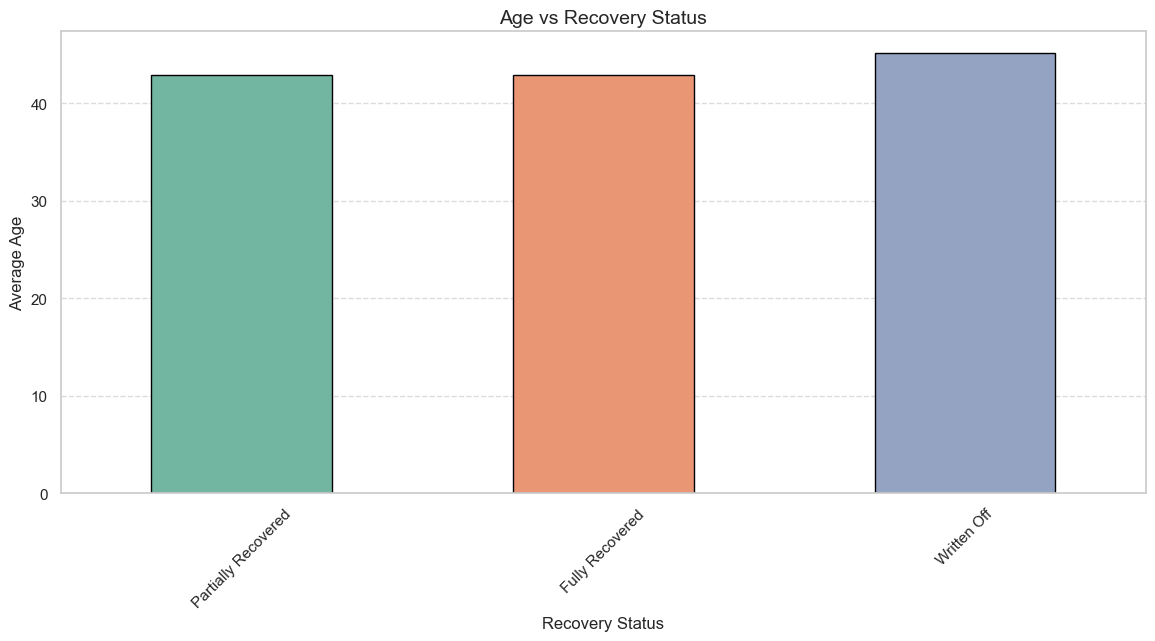

In [ ]:
plt.figure(figsize=(14, 6))  

ax = sns.barplot(
    x='Recovery_Status', y='Age', data=data, 
    hue='Recovery_Status', palette="Set2", legend=False, 
    edgecolor="black", errorbar=None, width=0.5  
)

plt.title("Age vs Recovery Status", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Average Age")
plt.xlabel("Recovery Status")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

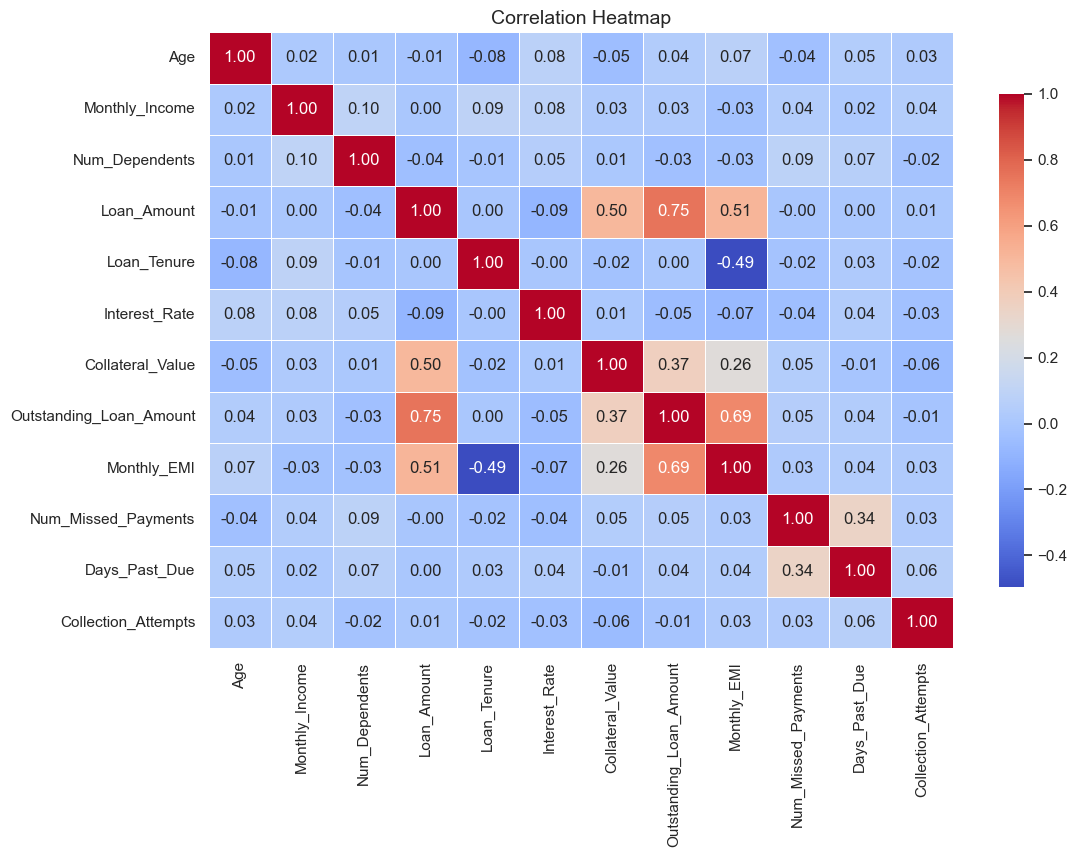

In [ ]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['number'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    numerical_data.corr(), annot=True, cmap="coolwarm",  
    fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8}  
)
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

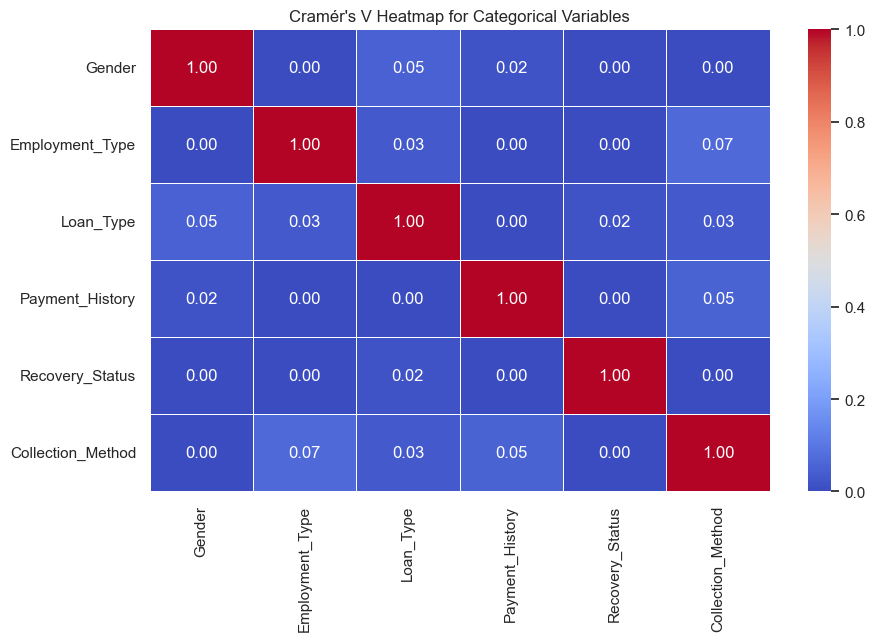

In [ ]:
# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((k_corr - 1), (r_corr - 1)))

# Compute Cramér's V for all categorical pairs
categorical_columns = ['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Recovery_Status', 'Collection_Method']
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Perfect correlation with itself
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

# Convert to float
cramers_v_matrix = cramers_v_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Heatmap for Categorical Variables")
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data['Gender'], data['Recovery_Status'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("There is a significant relationship between Gender and Recovery Status.")
else:
    print("No significant relationship between Gender and Recovery Status.")


Chi-Square Statistic: 1.7604761518404135
P-value: 0.4146841736122415
No significant relationship between Gender and Recovery Status.


Since p = 0.41 is greater than 0.05, there is no significant relationship between Gender and Recovery Status.

Gender does not impact loan recovery.

<Figure size 1400x600 with 0 Axes>

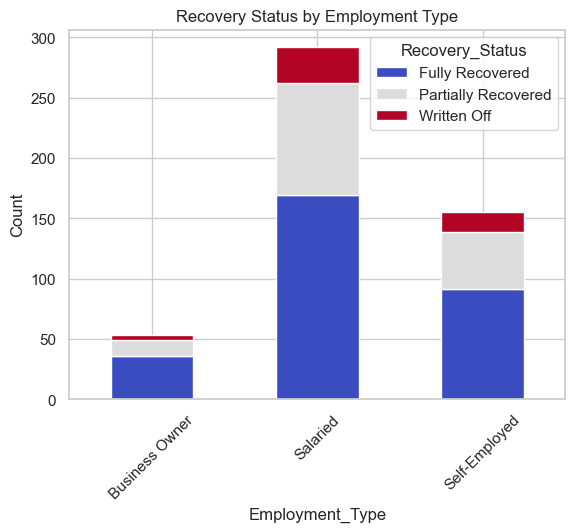

In [ ]:
plt.figure(figsize=(14, 6))
pd.crosstab(data['Employment_Type'], data['Recovery_Status']).plot(kind='bar', stacked=True, colormap="coolwarm")
plt.title("Recovery Status by Employment Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


## **Feature Engineering**

In [ ]:
# Feature Engineering
data["Debt_to_Income_Ratio"] = data["Loan_Amount"] / data["Monthly_Income"]
data["Missed_Payment_Ratio"] = data["Num_Missed_Payments"] / data["Loan_Tenure"]

# Handle division by zero by using assignment instead of inplace modification
data["Missed_Payment_Ratio"] = data["Missed_Payment_Ratio"].replace([np.inf, -np.inf], np.nan)
data["Missed_Payment_Ratio"] = data["Missed_Payment_Ratio"].fillna(0)

# Display new features
print(data[["Debt_to_Income_Ratio", "Missed_Payment_Ratio"]].head())


   Debt_to_Income_Ratio  Missed_Payment_Ratio
0              6.711459              0.000000
1             17.155010              0.000000
2             16.507123              0.027778
3             12.865280              0.027778
4              1.161344              0.020833


In [ ]:
#Define Features and Target
X = data.drop(columns=["Recovery_Status"])  # Features
y = data["Recovery_Status"]  # Target variable

In [ ]:
#Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  

#Identify categorical and numerical features
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [ ]:
#Data Preprocessing Pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [ ]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [ ]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)


In [ ]:
# Apply Preprocessing Before SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#Apply SMOTE (before converting to DataFrame)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

In [ ]:
#Convert Processed Arrays to DataFrame (With Column Names)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())



In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get probability predictions for all classes
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Calculate log loss only if probabilities exist
    log_loss_value = log_loss(y_test, y_prob) if y_prob is not None else "N/A"

    print(f"\n Model: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Log Loss:", log_loss_value)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return model

In [ ]:
#Initialize Models
log_reg = LogisticRegression(solver='liblinear', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(eval_metric="logloss", random_state=42)

#Train & Evaluate Models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb
}

for name, model in models.items():
    train_and_evaluate(model, X_train_resampled, y_train_resampled, X_test_processed, y_test, name)


🔹 Model: Logistic Regression
Accuracy: 0.64
Log Loss: 0.7923941398861752
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.68      0.73        59
           1       0.49      0.58      0.53        31
           2       0.46      0.60      0.52        10

    accuracy                           0.64       100
   macro avg       0.58      0.62      0.60       100
weighted avg       0.67      0.64      0.65       100

Confusion Matrix:
 [[40 17  2]
 [ 8 18  5]
 [ 2  2  6]]

🔹 Model: Random Forest
Accuracy: 0.85
Log Loss: 0.5913748450351826
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        59
           1       0.91      0.65      0.75        31
           2       1.00      0.60      0.75        10

    accuracy                           0.85       100
   macro avg       0.91      0.75      0.80       100
weighted avg       0.87      0.85      0.84    

## **Baseline Models**

| **Model (Baseline)**      | **Accuracy** | **Log Loss** | **Recall (Class 1 - Partially Recovered)** | **Recall (Class 2 - Written Off)** | **Weighted F1-Score** |
|--------------------------|------------|------------|----------------------------------|--------------------------------|------------------|
| **Logistic Regression**  | **0.64**   | **0.79**   | **58%**  | **60%**  | **0.65**  |
| **Random Forest**        | **0.85**   | **0.59**   | **65%**  | **60%**  | **0.84**  |
| **XGBoost**             | **0.84**   | **0.56**   | **65%**  | **60%**  | **0.83**  |

### **Key Insights:**
- **Logistic Regression** performed the worst, with lower accuracy and higher log loss.  
- **Random Forest and XGBoost** had strong accuracy and recall, but XGBoost had a slightly lower log loss (0.56 vs. 0.59).  
- **Both RF and XGBoost met the recall thresholds for Class 1 & Class 2**, making them better than Logistic Regression.  



In [ ]:
# Define parameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
}

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

def perform_grid_search(model_name, model, param_grid):
    """Performs GridSearchCV and returns the best model."""
    print(f"\n Hyperparameter Tuning for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    print(f"Best {model_name} Parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Perform GridSearchCV for both models
best_models = {name: perform_grid_search(name, models[name], param_grids[name]) for name in models}

# Evaluate best models
for name, best_model in best_models.items():
    train_and_evaluate(best_model, X_train_resampled, y_train_resampled, X_test_processed, y_test, f"{name} (Tuned)")



 Hyperparameter Tuning for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Hyperparameter Tuning for XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

🔹 Model: Random Forest (Tuned)
Accuracy: 0.85
Log Loss: 0.5913748450351826
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        59
           1       0.91      0.65      0.75        31
           2       1.00      0.60      0.75        10

    accuracy                           0.85       100
   macro avg       0.91      0.75      0.80       100
weighted avg       0.87      0.85      0.84       100

Confusion Matrix:
 [[59  0  0]
 [11 20  0]
 [ 2  2  6]]

🔹 Mod

## **After Hyperparameter Tuning**

| **Model (Tuned)**        | **Accuracy** | **Log Loss** | **Recall (Class 1 - Partially Recovered)** | **Recall (Class 2 - Written Off)** | **Weighted F1-Score** |
|--------------------------|------------|------------|----------------------------------|--------------------------------|------------------|
| **Random Forest (Tuned)** | **0.85**   | **0.59**   | **65%**  | **60%**  | **0.84**  |
| **XGBoost (Tuned)**      | **0.83**   | **0.55**   | **65%**  | **60%**  | **0.82**  |

### **Final Decision:**
- Both models had the **same recall for Class 1 & Class 2**, meaning they identified high-risk loans equally well.  
- **XGBoost had a lower Log Loss (0.55 vs. 0.59), meaning it made better-calibrated probability predictions.**  
- **XGBoost is more interpretable** with feature importance scores, making it easier to explain to stakeholders.  

**Final Choice:**  
We selected **XGBoost** because it has **better probability calibration, lower log loss, and strong recall for high-risk loans.**


In [ ]:
# Ensure the 'model' folder exists
os.makedirs("model", exist_ok=True)

# Save the tuned XGBoost model (from best_models) to the 'model' folder
joblib.dump(best_models["XGBoost"], "model/loan_recovery_model.pkl")

print("Model saved successfully as 'model/loan_recovery_model.pkl'!")

Model saved successfully as 'model/loan_recovery_model.pkl'!
